## Utilities

In [ ]:
# (if changes are made) Re-import our package.
for module in (dataset, visualization, preprocess, metric, model, neural_net, convnet1, losses, utilities):
    importlib.reload(module)

## Setup

In [1]:
# Configure matplotlib.
%matplotlib inline

In [2]:
# Import our package.
import sys, importlib
sys.path.append("/Users/sheaconlon/Dropbox/ludington/cell_counting")

from src import dataset, visualization, preprocess, metric, losses, utilities
from src.model import model
from src.model import neural_net
from src.model.segmentation.convnet1 import convnet1

/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [3]:
# Import other packages.
from IPython import display
import numpy as np

## Dataset and Preprocessing

In [4]:
# Load the dataset, processing it as a collection of image-mask pairs.
images_masks = dataset.Dataset(1)
images_masks.load_image_mask_pairs("/Users/sheaconlon/Dropbox/ludington/cell_counting/data/easy/raw/images",
                                   "/Users/sheaconlon/Dropbox/ludington/cell_counting/data/easy/raw/masks", (2448*2, 2448*2))

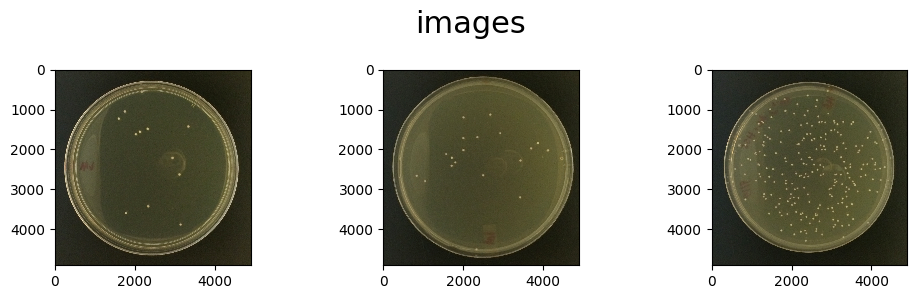

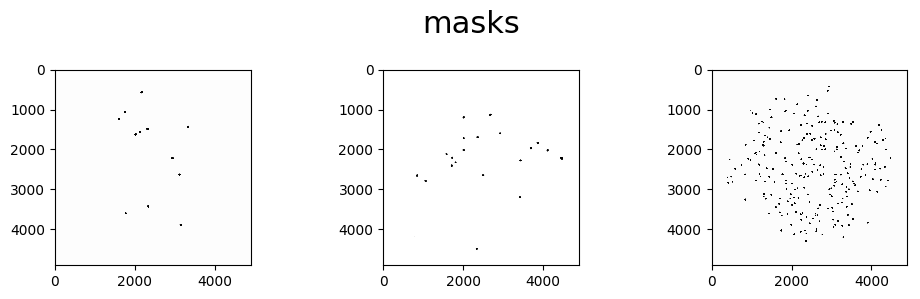

In [5]:
# Plot a batch.
inputs, outputs = images_masks.get_batch(3)
visualization.show_image_grid(inputs, 1, 3, 3, 10, "images")
visualization.show_image_grid(outputs, 1, 3, 3, 10, "masks")

In [ ]:
# Normalize the images.
#def normalize(batch):
#    inputs, outputs = batch
#    inputs = preprocess.smdm_normalize(inputs, 61, "REFLECT")
#    return (inputs, outputs)
#images_masks.map_batch(normalize)

In [ ]:
# Plot a batch.
#inputs, outputs = images_masks.get_batch(3)
#visualization.show_image_grid(inputs, 1, 3, 2, 6, "images")
#visualization.show_image_grid(outputs, 1, 3, 2, 6, "masks")

In [6]:
# Extract patches from the images.
WHITE_MIN = 250
GRAY_MIN = 200
NUM_PATCHES = 1000
NUM_SEGMENTS = 10

def mask_patches_to_classes(mask_patches):
    mask_patches = np.mean(mask_patches, axis=3)
    n, h, w = mask_patches.shape
    x_center, y_center = h//2 + 1, w//2 + 1
    patches_are_edge_or_inside = (mask_patches[:, x_center, y_center] < WHITE_MIN).flatten()
    patches_are_inside = (mask_patches[:, x_center, y_center] < GRAY_MIN).flatten()
    classes = np.zeros((n))
    classes[patches_are_edge_or_inside] = 1
    classes[patches_are_inside] = 2
    return classes

def extract_patches(example):
    image, mask = example
    image_patches = utilities.print_time(preprocess.extract_patches, "image patch extraction")(image, 61, NUM_PATCHES)
    mask_patches = utilities.print_time(preprocess.extract_patches, "mask patch extraction")(mask, 61, NUM_PATCHES)
    classes = utilities.print_time(mask_patches_to_classes, "mask patches to classes")(mask_patches)
    examples = [(image_patches[i, ...] / 255, classes[i]) for i in range(classes.shape[0])]
    return examples

images_masks.map(extract_patches)
utilities.print_time(images_masks.set_segment_size, "segment resizing")(NUM_PATCHES // NUM_SEGMENTS)

image patch extraction took 1 seconds
mask patch extraction took 1 seconds
mask patches to classes took 0 seconds
image patch extraction took 2 seconds
mask patch extraction took 2 seconds
mask patches to classes took 0 seconds
image patch extraction took 3 seconds
mask patch extraction took 4 seconds
mask patches to classes took 0 seconds
segment resizing took 0 seconds


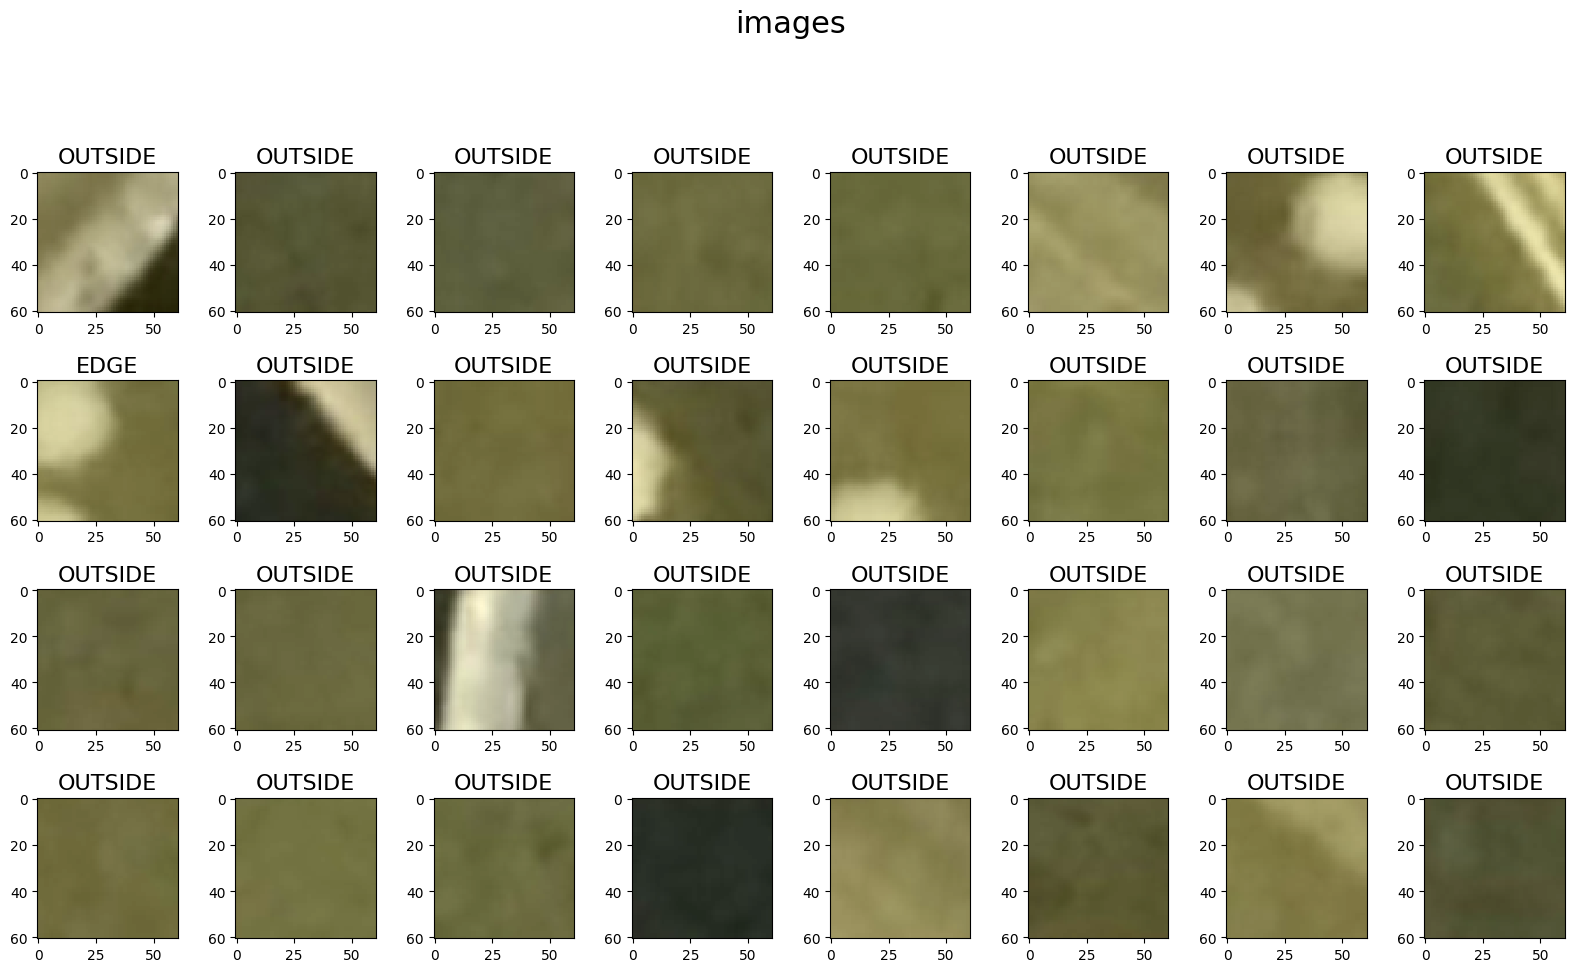

In [7]:
# Plot a batch.
CLASS_NAMES = {0:"OUTSIDE", 1:"EDGE", 2:"INSIDE"}

inputs, outputs = images_masks.get_batch(4*8)
visualization.show_image_grid(inputs * 255, 4, 8, 2.5*4, 16, "images",
                              [CLASS_NAMES[outputs[i]] for i in range(outputs.shape[0])])

In [8]:
# One-hot encode the labels.
import tensorflow as tf

def one_hot_encode(batch):
    inputs, outputs = batch
    with tf.Session().as_default():
        return inputs, tf.one_hot(tf.constant(outputs, dtype=tf.int32), 3).eval()
    
images_masks.map_batch(one_hot_encode)

In [9]:
# Split the dataset.
train, test = images_masks.split(0.1)
images_masks.close()

## Model and Training

In [10]:
# Create the net.
import tensorflow as tf
net = convnet1.ConvNet1("saves/18-01-20-PM-07-08", 120, train.size())

INFO:tensorflow:Using config: {'_model_dir': 'saves/18-01-20-PM-07-08', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 120, '_session_config': None, '_keep_checkpoint_max': 2, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x12525af28>, '_task_type': 'worker', '_task_id': 0, '_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [11]:
# Create some metrics.
train_data = train.get_batch(250)
test_data = test.get_batch(250)
def loss_fn(predicted, actual):
    loss = tf.losses.softmax_cross_entropy(actual, predicted)
    with tf.Session().as_default():
        return loss.eval()
metrics = {
    "train_loss": metric.LossMetric(train_data, loss_fn),
    "test_loss": metric.LossMetric(test_data, loss_fn),
    "conf_mtx": metric.ConfusionMatrixMetric(test_data, 3),
    "nx_conf_mtx": metric.NonexclusiveConfusionMatrixMetric(test_data, 3)
}

In [12]:
# Make a function for plotting the metrics.
def plot_metrics():
    xs, ys = metrics["train_loss"].get_results()
    visualization.plot_line(xs, ys, "Training Loss", "training examples seen", "cross-entropy loss on training data",
                            3, 10)
    xs, ys = metrics["test_loss"].get_results()
    visualization.plot_line(xs, ys, "Test Loss", "training examples seen", "cross-entropy loss on test data", 3, 10)
    xs, ys = metrics["conf_mtx"].get_results()
    visualization.plot_confusion_matrix(ys[-1], "Test Confusion Matrix", 5, 5)
    xs, ys = metrics["nx_conf_mtx"].get_results()
    visualization.plot_confusion_matrix(ys[-1], "Nonexclusive Test Confusion Matrix", 5, 5)

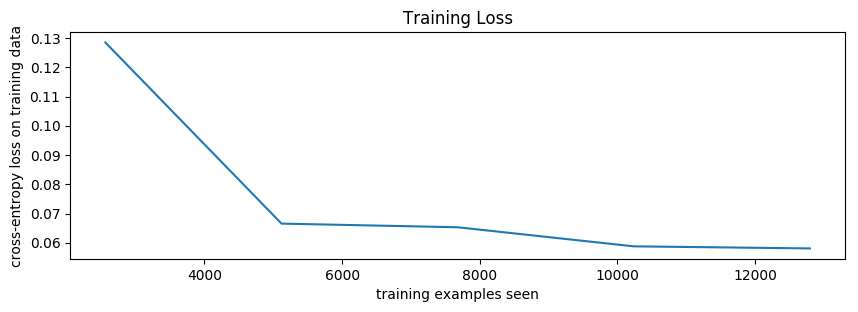

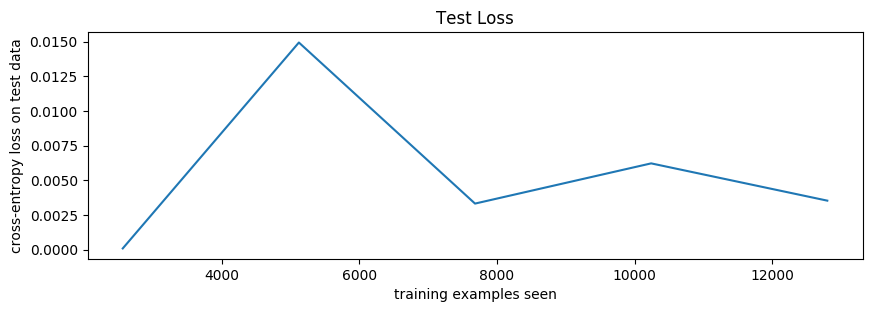

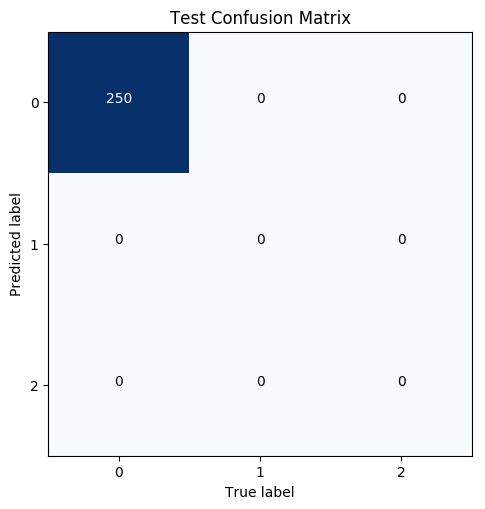

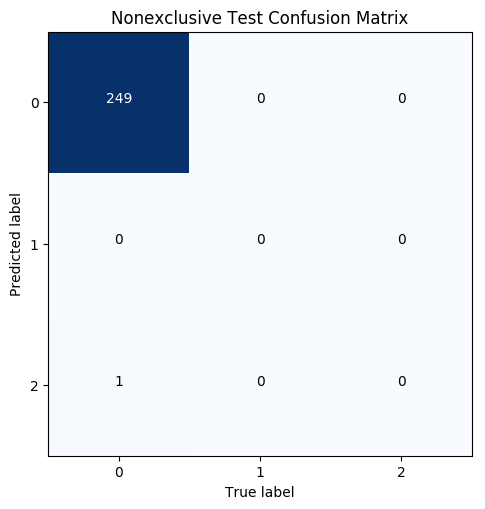

KeyboardInterrupt: 

In [13]:
# Alternately train and evaluate the net for 20 minutes.
for _ in range(10):
    net.train(train, 3*60)
    net.evaluate(metrics)
    display.clear_output()
    plot_metrics()

## Cleanup

In [ ]:
# Close the datasets.
train.close()
test.close()